In [1]:
import pandas as pd
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

In [2]:
mergedData = pd.read_excel('TabellaFinale.xlsx', sheet_name=None)

In [3]:
mergedData['Sheet1'].head()

Unnamed: 0  HDN_CODE Sesso  ETA                DATA  ASCVD_Score  DATA_INT  \
0           7      2236     M   64 2021-02-26 00:00:00        27.30       422   
1           6      6426     M   47 2021-04-02 00:00:00         2.56       457   
2          18      8377     M   56 2020-08-31 00:00:00         7.80       243   
3          51     11463     M   71 2020-08-31 00:00:00        24.74       243   
4          53     11463     M   71 2021-03-31 10:54:33          NaN       456   

   num_visita  Charlson_Totale Charlson_Diabete  ...  DASS21 stress  \
0           0              NaN              NaN  ...            0.0   
1           0              2.0           0 = No  ...            3.0   
2           0              1.0           0 = No  ...            NaN   
3           0              3.0           0 = No  ...            NaN   
4           1              NaN              NaN  ...            0.0   

   Stress level  DASS21 anxiety  Anxiety level  DASS21 depression  \
0        Normal             0.0         Normal                0.0   
1        Normal             4.0           Mild                7.0   
2           NaN             NaN            NaN                NaN   
3           NaN             NaN            NaN                NaN   
4        Normal             0.0         Normal                0.0   

   Depression level  Insomnia severity index  \
0            Normal                      8.0   
1          Moderate                      6.0   
2               NaN                      NaN   
3               NaN                      NaN   
4            Normal                      0.0   

                            ISI level  SF36 general health Resilience  
0               Subthreshold Insomnia                 75.0       64.0  
1  No Clinically Significant Insomnia                 10.0       54.0  
2                                 NaN                  NaN        NaN  
3                                 NaN                  NaN        NaN  
4  No Clinically Significant Insomnia                 90.0       88.0  

[5 rows x 80 columns]

In [4]:
# tolgo la prima colonna e seleziono il primo foglio
df = mergedData['Sheet1'].iloc[:, 1:]

In [5]:
df.head()

HDN_CODE Sesso  ETA                DATA  ASCVD_Score  DATA_INT  num_visita  \
0      2236     M   64 2021-02-26 00:00:00        27.30       422           0   
1      6426     M   47 2021-04-02 00:00:00         2.56       457           0   
2      8377     M   56 2020-08-31 00:00:00         7.80       243           0   
3     11463     M   71 2020-08-31 00:00:00        24.74       243           0   
4     11463     M   71 2021-03-31 10:54:33          NaN       456           1   

   Charlson_Totale Charlson_Diabete  Stifness  ...  DASS21 stress  \
0              NaN              NaN       6.7  ...            0.0   
1              2.0           0 = No       NaN  ...            3.0   
2              1.0           0 = No       NaN  ...            NaN   
3              3.0           0 = No       NaN  ...            NaN   
4              NaN              NaN       NaN  ...            0.0   

   Stress level  DASS21 anxiety  Anxiety level  DASS21 depression  \
0        Normal             0.0         Normal                0.0   
1        Normal             4.0           Mild                7.0   
2           NaN             NaN            NaN                NaN   
3           NaN             NaN            NaN                NaN   
4        Normal             0.0         Normal                0.0   

   Depression level  Insomnia severity index  \
0            Normal                      8.0   
1          Moderate                      6.0   
2               NaN                      NaN   
3               NaN                      NaN   
4            Normal                      0.0   

                            ISI level SF36 general health Resilience  
0               Subthreshold Insomnia                75.0       64.0  
1  No Clinically Significant Insomnia                10.0       54.0  
2                                 NaN                 NaN        NaN  
3                                 NaN                 NaN        NaN  
4  No Clinically Significant Insomnia                90.0       88.0  

[5 rows x 79 columns]

In [6]:
dfSenzaData = df.drop(columns=['DATA', 'num_visita', 'DATA_INT'])

In [7]:

#dfSenzaData.to_excel('TabellaFinaleSenzaDataInde.xlsx')

In [8]:
dfSenzaData = dfSenzaData[(dfSenzaData['FrailtyPhenotypeBool'].notna()) & (dfSenzaData['Resilience'].notna())]

In [9]:
soloETA = dfSenzaData[['HDN_CODE','Alcool', 'Fumatore', 'FrailtyPhenotypeBool', 'PersoPeso', 'Charlson_Totale']]
soloETA.to_csv('TabellaFinaleSenzaDataCorrelatedParziale_2.csv')

In [10]:
#soloETA.to_csv('SoloETA.csv')

## Parametri utente

In [11]:
input_data = 'TabellaFinaleSenzaDataCorrelatedParziale_2.csv' 
mode = 'correlated_attribute_mode'
description_file = 'description_parziale_correlated_2.json'
synthetic_data = 'synthetic_data_correlated_parziale.csv'

In [12]:
# An attribute is categorical if its domain size is less than this threshold.
threshold_value = 15

# specify categorical attributes
categorical_attributes = {'Sesso':True,
                            #'num_visita':True,
                            'Charlson_Diabete':True,
                            'Charlson_Totale':True,
                            'FrailtyPhenotypeBool':True,
                            'Pneumo_ScalaBorg':True,
                            'TestCammino6Min_BorgBase':True,
                            'TestCammino6Min_BorgEnd':True,
                            'Alcool':True,
                            'Fumatore':True,
                            'Sintomi_Cadute':True,
                            'Sintomi_DifficoltaDeglutizione':True,
                            'Sintomi_DistUdito':True,
                            'Sintomi_DistVista':True,
                            'SintomiNeuropsico_Ageusia':True,
                            'SintomiNeuropsico_Anosmia':True,
                            'SintomiNeuropsico_Astenia':True,
                            'SintomiNeuropsico_CognitivoAttenzione':True,
                            'SintomiNeuropsico_CognitivoConcentrazione':True,
                            'SintomiNeuropsico_CognitivoMemoria':True,
                            'SintomiNeuropsico_DistEquilibrio':True,
                            'SintomiNeuropsico_DistSonno':True,
                            'SintomiNeuropsico_DoloriMuscolari':True,
                            'SintomiNeuropsico_Effluvium':True,
                            'Descrizione':True,
                            'AssumePiuFarmaciGiorno':True,
                            'PersoPeso':True,
                            'CamminareMenoUltimoAnno':True,
                            'CaduteUltimoAnno':True,
                            'SentirsiSolo':True,
                            'PuoContareSuQualcuno':True,
                            'DifficoltaEconomicheSpeseSanitarie':True,
                            'EQ5D5L health score':True,
                            'DASS21 stress':True,
                            'Anxiety level':True,
                            'DASS21 depression':True,
                            'Depression level':True,
                            'Insomnia severity index':True,
                            'ISI level':True
                         }

# specify which attributes are candidate keys of input dataset.
candidate_keys = {'HDN_CODE':True}

# A parameter in Differential Privacy. It roughly means that removing a row in the input dataset will not 
# change the probability of getting the same output more than a multiplicative difference of exp(epsilon).
# Increase epsilon value to reduce the injected noises. Set epsilon=0 to turn off differential privacy.
epsilon = 1

# The maximum number of parents in Bayesian network, i.e., the maximum number of incoming edges.
degree_of_bayesian_network = 2

# Number of tuples generated in synthetic dataset.
num_tuples_to_generate = 1000

In [13]:
# istanzio il data describer
describer = DataDescriber(category_threshold=threshold_value)
describer.describe_dataset_in_correlated_attribute_mode(dataset_file=input_data, 
                                                        epsilon=epsilon,
                                                         k = degree_of_bayesian_network,
                                                        attribute_to_is_categorical=categorical_attributes,
                                                        attribute_to_is_candidate_key=candidate_keys)
describer.describe_dataset_in_random_mode(input_data)
describer.save_dataset_description_to_file(description_file)

================ Constructing Bayesian Network (BN) ================
Adding ROOT PersoPeso
Adding attribute FrailtyPhenotypeBool
Adding attribute Alcool
Adding attribute Fumatore
Adding attribute Charlson_Totale
========================== BN constructed ==========================


In [14]:
display_bayesian_network(describer.bayesian_network)

Constructed Bayesian network:
    FrailtyPhenotypeBool has parents ['PersoPeso'].
    Alcool               has parents ['FrailtyPhenotypeBool', 'PersoPeso'].
    Fumatore             has parents ['Alcool', 'FrailtyPhenotypeBool'].
    Charlson_Totale      has parents ['Alcool', 'PersoPeso'].


In [15]:

generator = DataGenerator()
generator.generate_dataset_in_correlated_attribute_mode(num_tuples_to_generate, description_file)
generator.save_synthetic_data(synthetic_data)

In [16]:
dfs = pd.read_csv(synthetic_data)

(array([  4.,  10.,  11.,  42.,  81., 108., 119.,  71.,  83.,  22.]),
 array([14. , 21.5, 29. , 36.5, 44. , 51.5, 59. , 66.5, 74. , 81.5, 89. ]),
 <BarContainer object of 10 artists>)

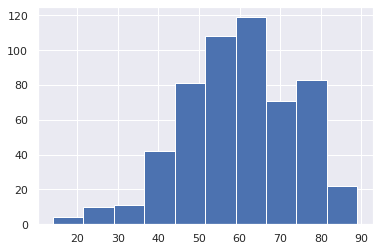

In [17]:
plt.hist(df['ETA'])

In [18]:
#plt.hist(dfs['ETA'])

KeyError: 'ETA'

## Ispector

In [19]:
# Read both datasets using Pandas.
input_df = df
synthetic_df = dfs.iloc[:, 1:]
# Read attribute description from the dataset description file.
attribute_description = read_json_file(description_file)['attribute_description']

inspector = ModelInspector(input_df, synthetic_df, attribute_description)


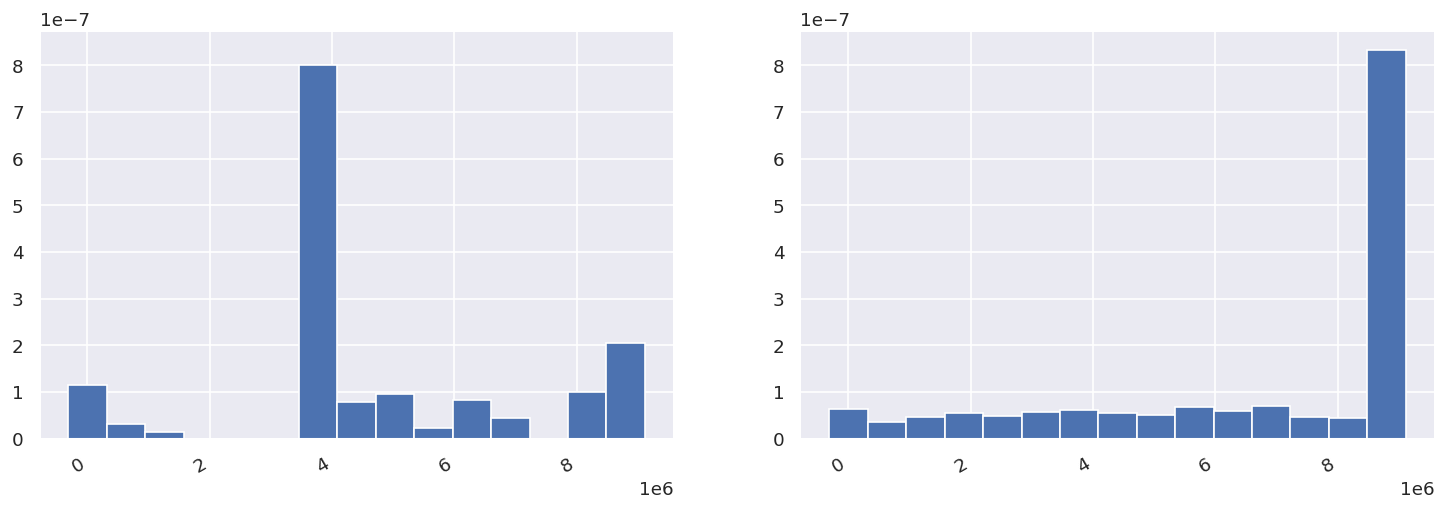

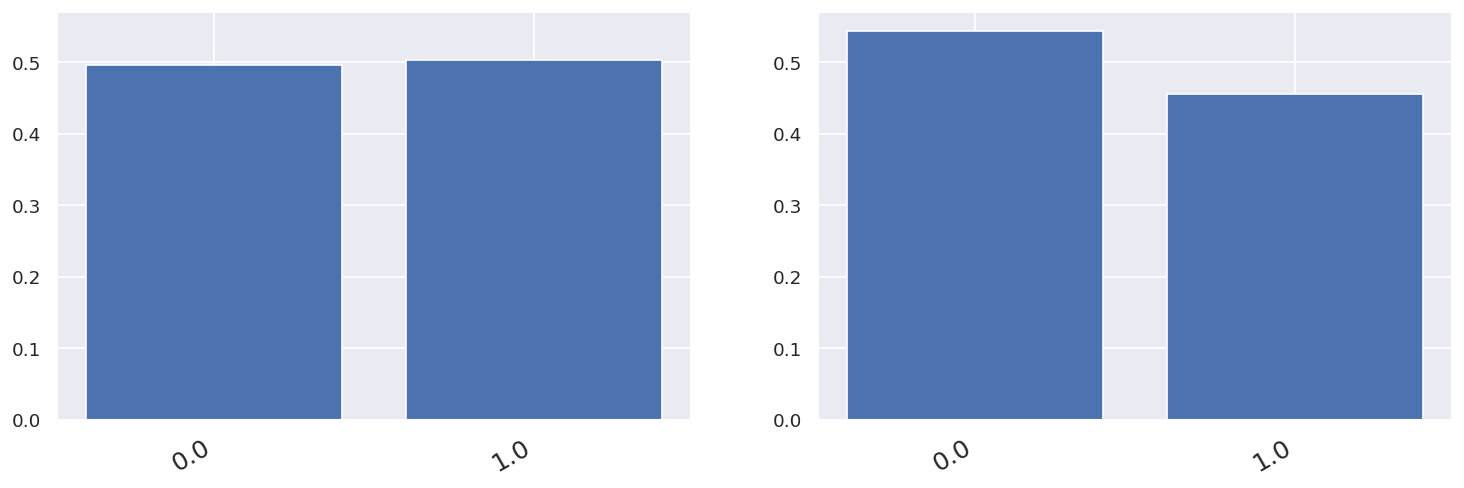

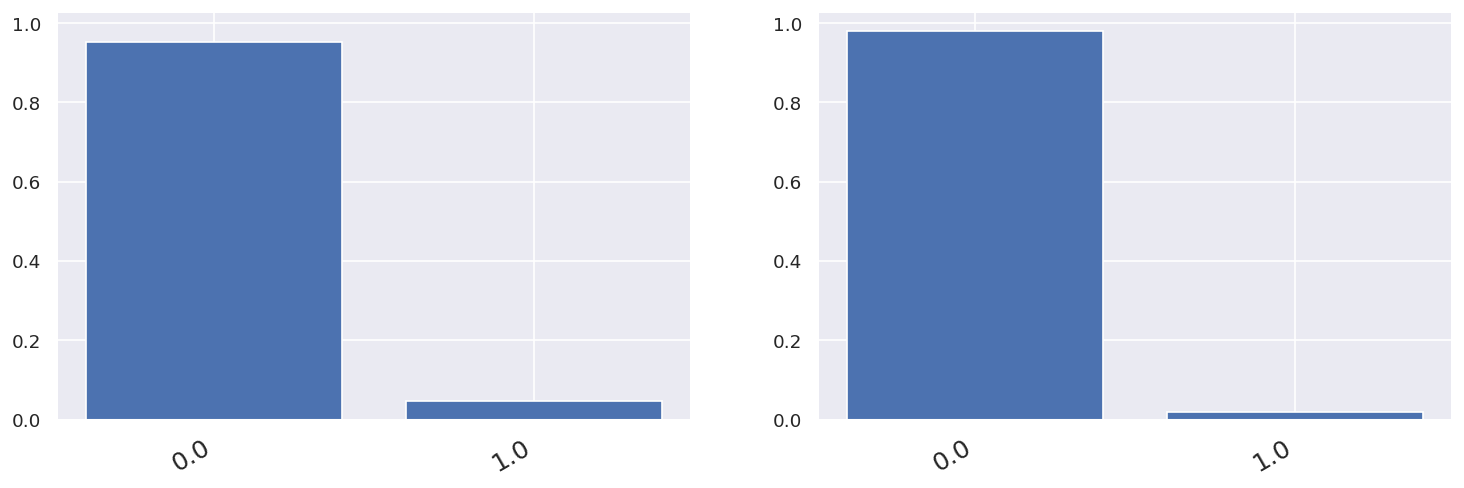

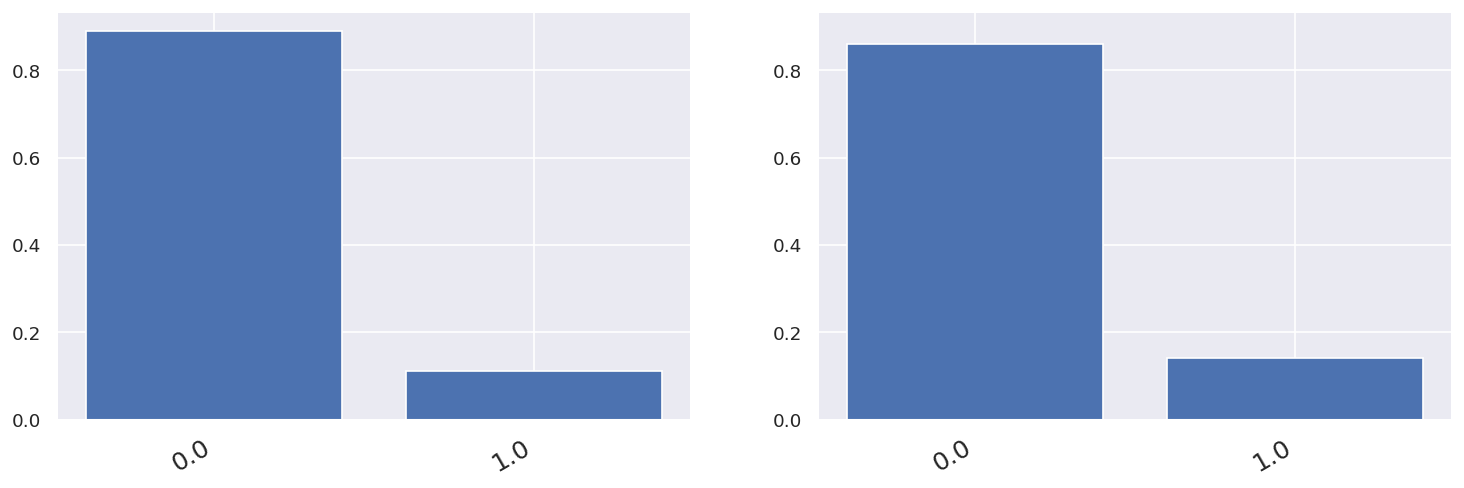

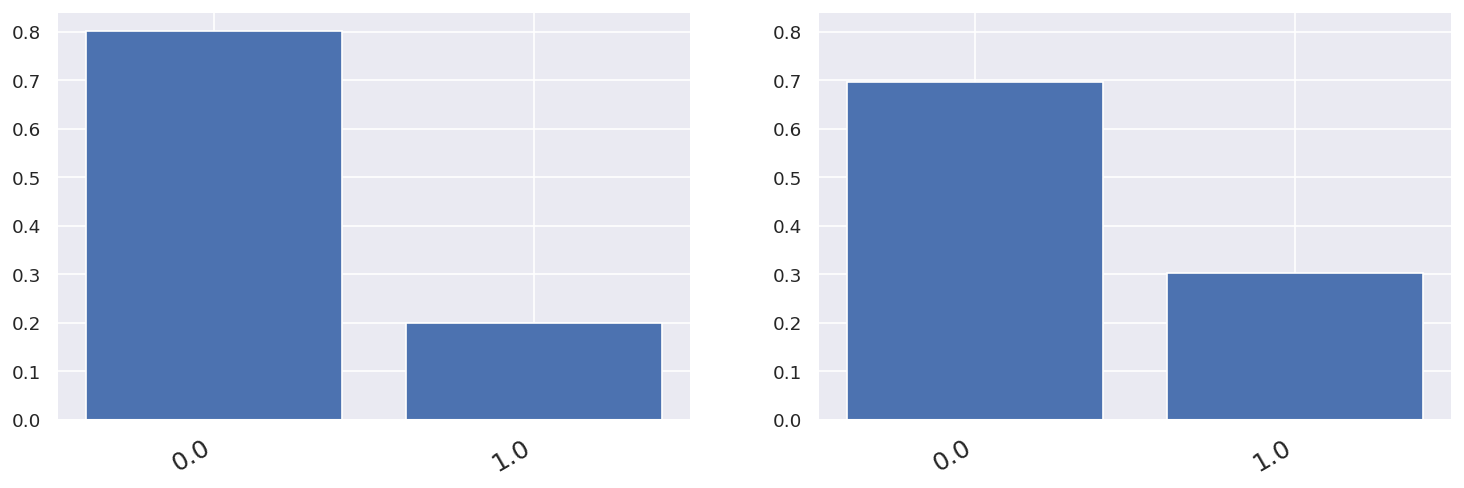

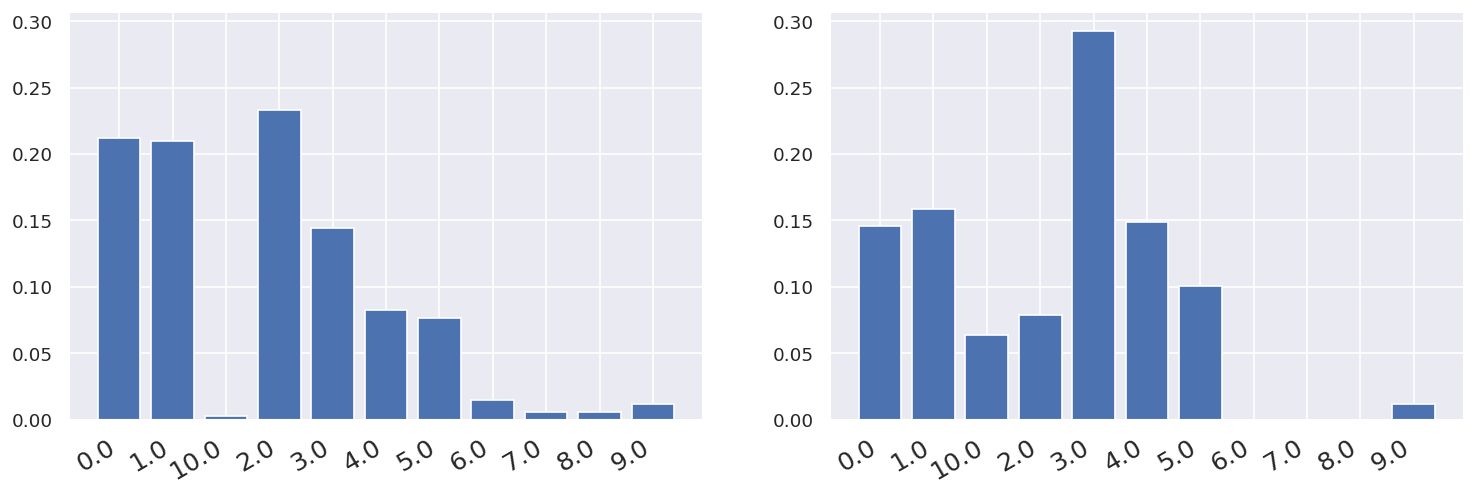

In [20]:
for attribute in synthetic_df.columns:
    inspector.compare_histograms(attribute)

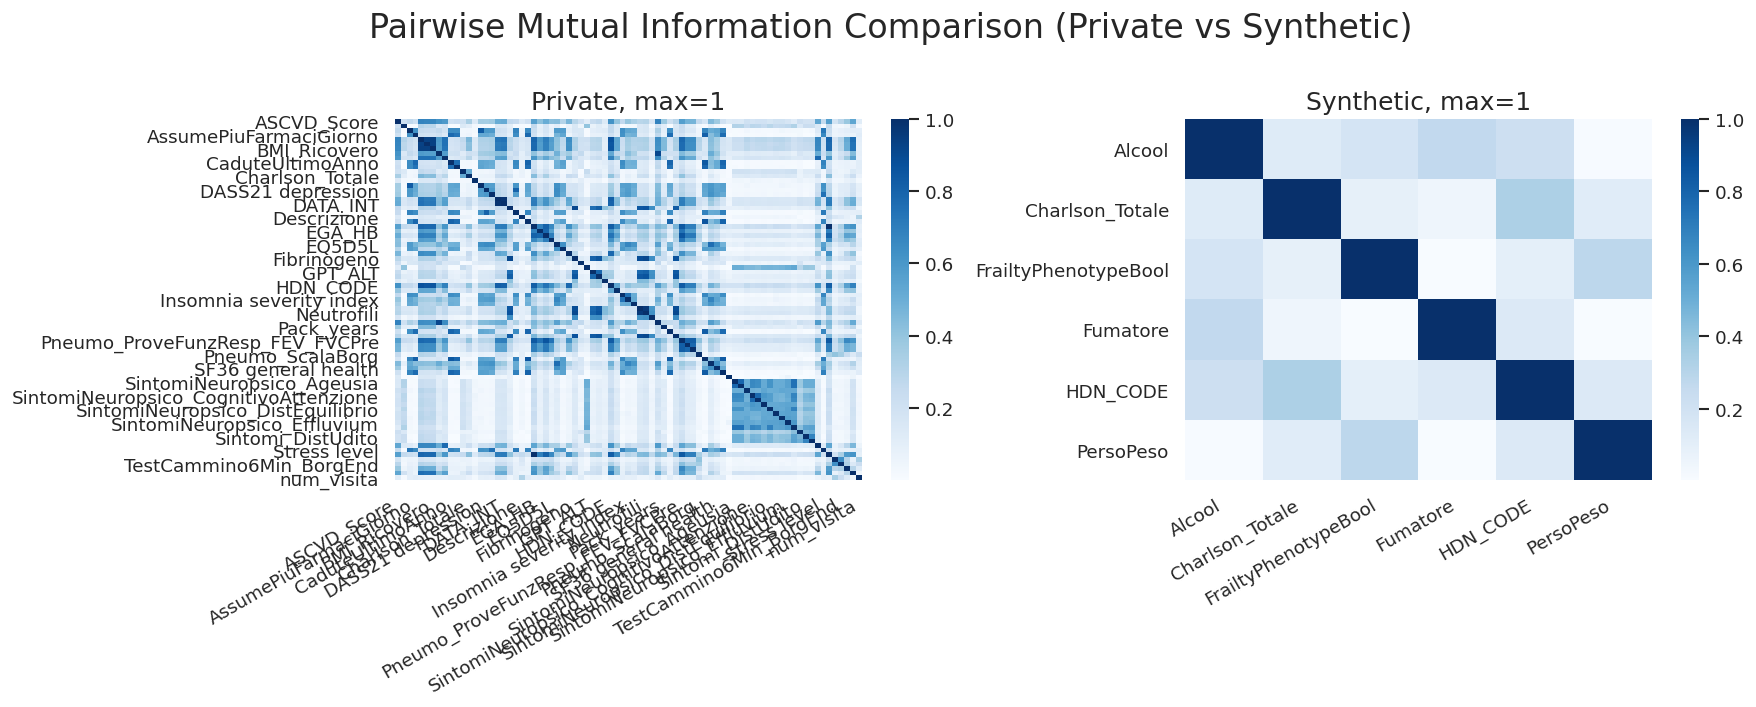

In [21]:
inspector.mutual_information_heatmap()

In [22]:
synthetic_df.head()

HDN_CODE  Alcool  Fumatore  FrailtyPhenotypeBool  PersoPeso  \
0  7961376.0     NaN       NaN                   0.0        0.0   
1  7146372.0     1.0       0.0                   0.0        1.0   
2  3966354.0     0.0       0.0                   0.0        0.0   
3  2442669.0     0.0       0.0                   0.0        0.0   
4  4821281.0     1.0       0.0                   0.0        0.0   

   Charlson_Totale  
0              NaN  
1              4.0  
2              NaN  
3              4.0  
4              1.0

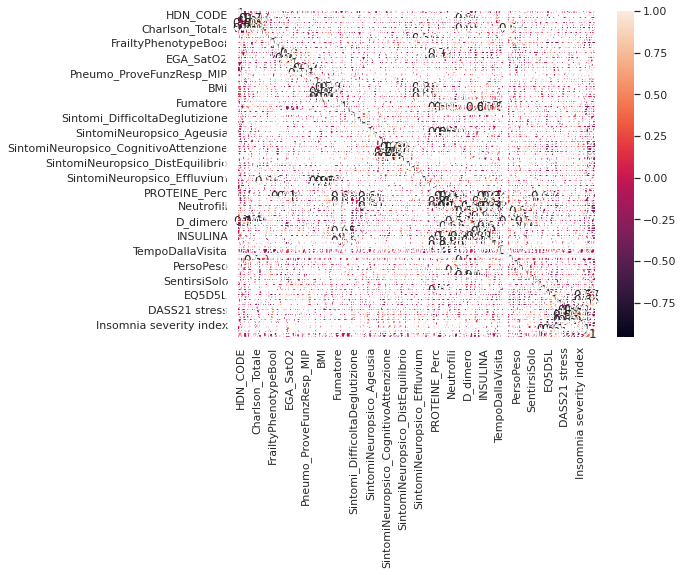

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(dfSenzaData.corr(), annot=True)
plt.show()